# Iceberg Classifier Challenge


## Introduction

This project will predict whether an image contains a ship or an iceberg with machine learning.

## Load Modules

In [1]:
# Data Manipulation
import pandas as pd
pd.options.display.max_columns = 25
import numpy as np
from IPython.display import display

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {"axes.grid": False})
import missingno as msno

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

/Users/courtneyfergusonlee/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [2]:
# test, train and submission files
#test = pd.read_json('data/test.json')

train = pd.read_json('data/train.json')
train_df = pd.DataFrame(train)

submission = pd.read_csv('data/sample_submission.csv')

## Data Structure

### Basic Structure

shape
info
describe

In [3]:
train_df.shape

(1604, 5)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


In [5]:
train_df.describe()

,is_iceberg
count,1604.000000
mean,0.469451
std,0.499222
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


Looks like pandas read the inc_angle as text. We'll have to convert that to a float.

### Missing Data

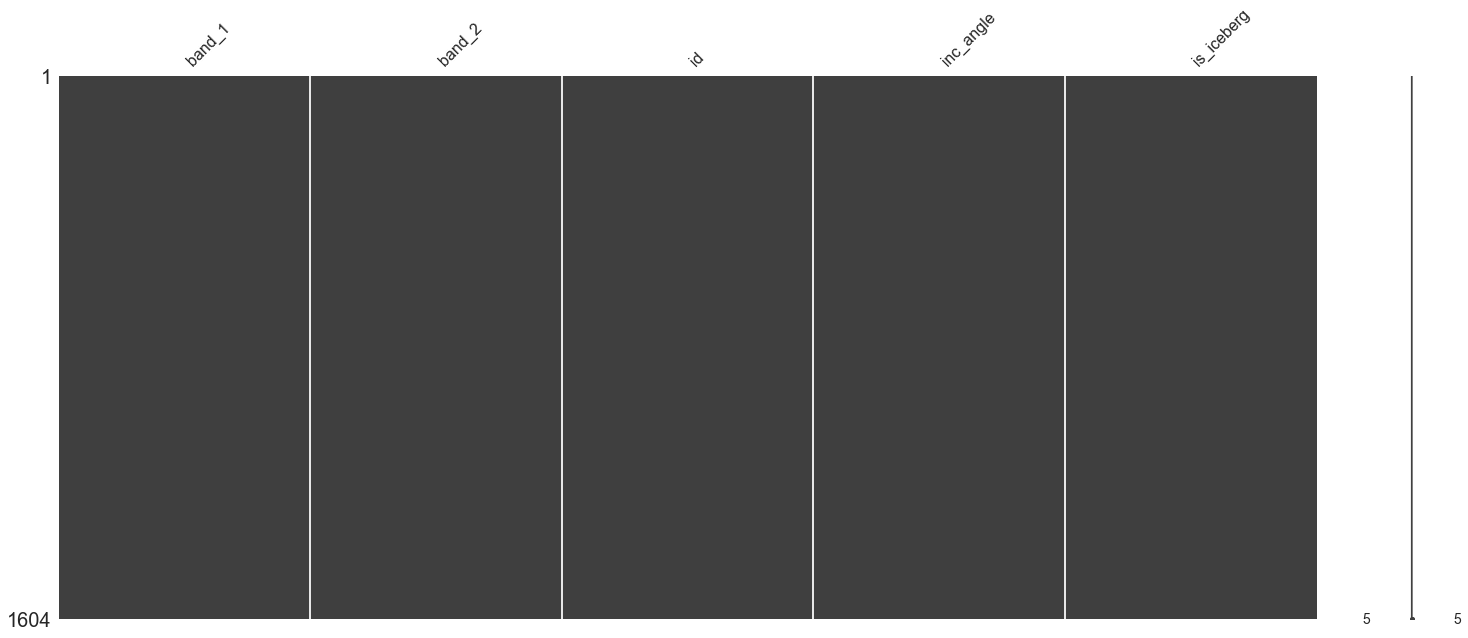

In [7]:
msno.matrix(train_df)

## Data Cleaning

We know we at least need to change inc_angle from a string to a float

In [8]:
train_df.replace('na', np.NaN, inplace=True)
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1471 non-null float64
is_iceberg    1604 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 75.2+ KB


## Visualizations

Plot a sample image and an 8 by 8 array of samples

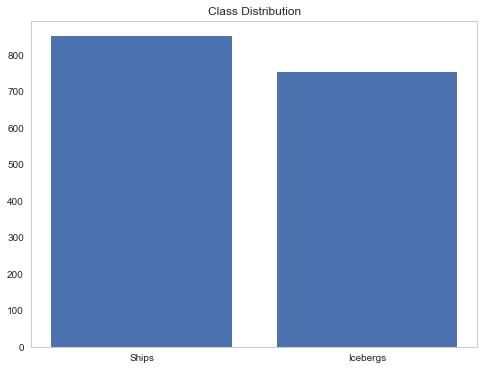

In [9]:
val_counts = train_df.is_iceberg.value_counts()
plt.figure(figsize=(8,6))
plt.bar(
    val_counts.index,
    val_counts.values
)
plt.xticks(range(2), ['Ships', 'Icebergs'])
plt.title('Class Distribution')
plt.show()

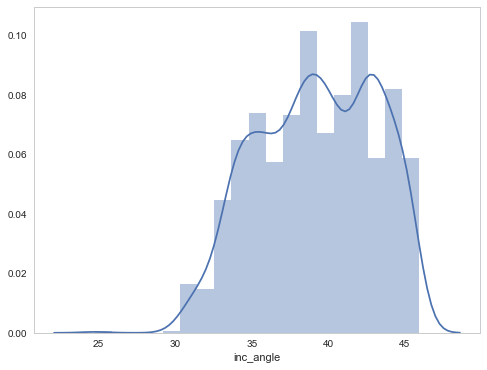

In [10]:
val_counts = train_df.inc_angle.value_counts()
plt.figure(figsize=(8,6))
sns.distplot(
    train_df.inc_angle.dropna()
)
plt.show()

In [11]:
band_1_ex = train_df.loc[0, 'band_1']
band_1_ex = np.array(band_1_ex)
band_1_square = band_1_ex.reshape(75, 75)

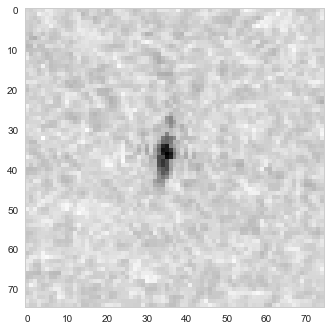

In [12]:
plt.imshow(band_1_square)
plt.show()

In [13]:
band_2_ex = train_df.loc[0, 'band_2']
band_2_ex = np.array(band_2_ex)
band_2_square = band_2_ex.reshape(75, 75)

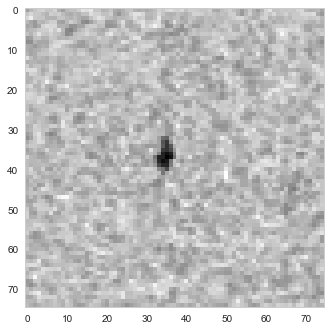

In [14]:
plt.imshow(band_2_square)
plt.show()

In [15]:
band_1_ex = train_df.loc[0, 'band_1']
band_2_ex = train_df.loc[0, 'band_2']
band_sub_1 = np.array(band_1_ex)
band_sub_2 = np.array(band_2_ex)
band_sub = band_sub_1 - band_sub_2
band_sub_square = band_sub.reshape(75, 75)

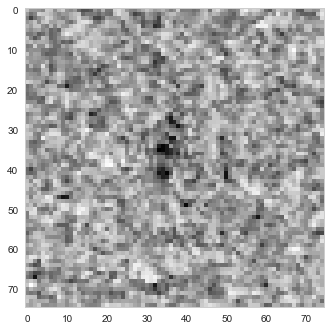

In [16]:
plt.imshow(band_sub_square)
plt.show()

In the example pics, the contrast between the hh and hv iceberg images is greater than the contrast between the hh and hv ship images. Icebergs seem to "disappear" under hv images, while ships are clearly visible in both hv and hh images. That difference in contrast may be the key.

In [17]:
def plot_image_grid(train, band_type, n_row, n_col):
    band = 'band_1'
    if band_type=='HV Images':
        band = 'band_2'
    classification = ''
    # Plot the first 8 eignenvalues
    plt.figure(figsize=(11,11))
    for i in list(range(n_row * n_col)):
    #     for offset in [10, 30,0]:
    #     plt.subplot(n_row, n_col, i + 1)
    #     offset =0
        sat_image = train.loc[i, band]
        sat_image = np.array(sat_image)
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(sat_image.reshape(75,75))
        
        if train.loc[i, 'is_iceberg']:
            classification = 'Iceberg'
        else:
            classification = 'Ship'
        title_text = "{0} {1:.0f}".format(classification, train.loc[i, 'inc_angle'])
        plt.title(title_text, size=6.5)
        plt.xticks(())
        plt.yticks(())
    plt.suptitle(band_type)
    plt.show()


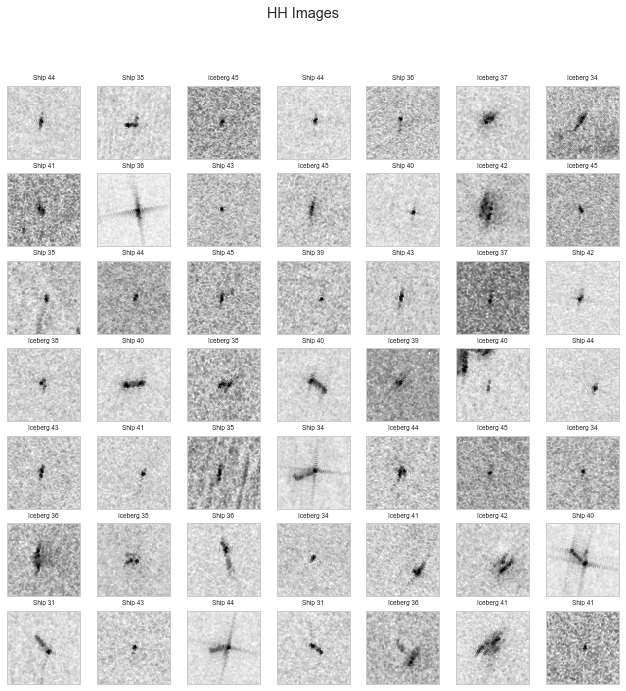

In [18]:
plot_image_grid(train_df, 'HH Images', 7, 7)

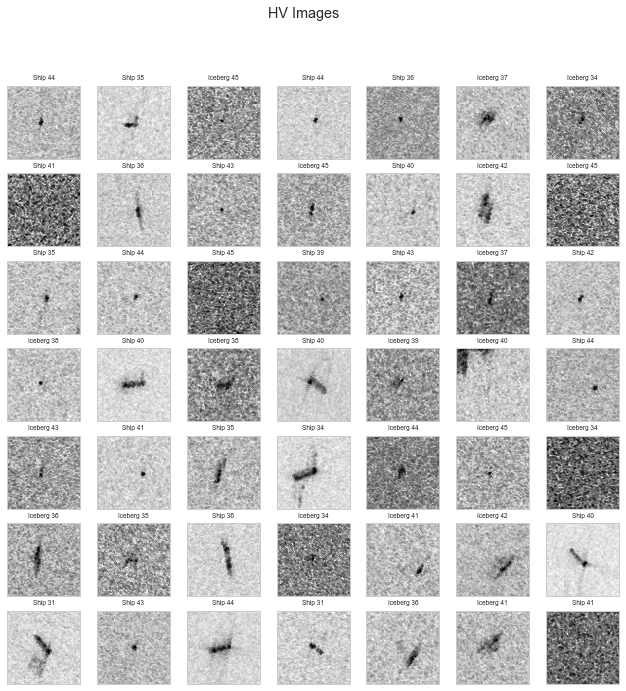

In [19]:
plot_image_grid(train_df, 'HV Images', 7, 7)

## Feature Engineering

Need a way to feed the data from the two images into the classifier.

First thought:
Subtract the two arrays and use the incidence angle as just another column.

- Turn each band cell into a numpy array
- The whole column can be a higher dimensional array
- Subtract the two arrays
- Turn the inc_angle column into a numpy array
- Concatenate the difference and inc_angle columns
- Feed into algorithm

In [20]:
band_1_arr = train_df.band_1.apply(np.asarray)
band_2_arr = train_df.band_2.apply(np.asarray)
band_diff = band_1_arr - band_2_arr
band_diff_series = band_diff.apply(pd.Series)

In [21]:
first_idea = pd.concat((band_diff_series, train_df.inc_angle), axis=1)

## Dimensionality Reduction

Need to explore digit recognition notebooks on:
- PCA
- The other two

What increases accuracy from 94% to 99.9%?

## Models

- Randomforest
- XGboost
- Research!

- split into x and y
- split into train and test
- fit
- test
- measure accuracy
  - Accuracy score
  - Confusion matrix
  - 

In [22]:
forest = RandomForestClassifier(random_state=42)

x = first_idea[first_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
print "Classification Report"
print classification_report(y_test, pred)
conf_matrix = confusion_matrix(y_test, pred)

Classification Report
             precision    recall  f1-score   support

          0       0.59      0.70      0.64       211
          1       0.67      0.55      0.61       231

avg / total       0.63      0.62      0.62       442



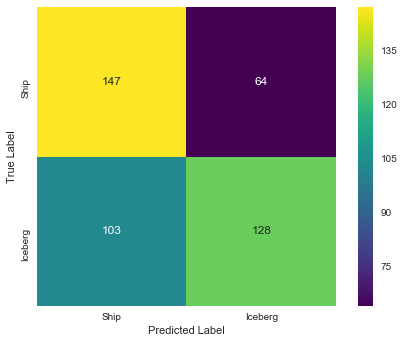

In [23]:
conf_df = pd.DataFrame(conf_matrix)
conf_df.columns = ['Ship', 'Iceberg']
conf_df.index = ['Ship', 'Iceberg']

#plt.figure(figsize=(12,8))
sns.heatmap(
    conf_df,
    square=True,
    annot=True,
    cmap='viridis',
    fmt='0g'
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()